# Notebook 2: SIR Simulation Model Estimation
### Peter.Nolan@gmail.com
### https://github.com/dpnolan/pandemic

# Introduction ##

SIR model estimation from SIR model data

- S(t) is the number of people susceptible to becoming infected (no immunity)
- I(t) is the number of people currently infected (and infectious)
- R(t) is the number of recovered people(SIR assumes that they remain immune)
- alpha $\alpha$ is the constant rate of infectious contact between people often called transmission rate
- gamma $\gamma$ is the rate of recovery of infected individuals, 1 over the days to recovery
- $R_0$ derived from them

## Data sources 
Estimation uses datasets generated by Notebook 1, a user-entered simulation

File
__sir.csv__

## Setup

uses kernel pymc_env_1 on PC

In [1]:
#!conda list --export > requirements.txt

In [2]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import arviz as az
from pytensor import scan
import matplotlib.pyplot as plt
from datetime import datetime

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Input Data

In [3]:
dataset="SIR simulation"
df = pd.read_csv("sir.csv").astype('float64').astype('float64') # Data generated by the SIR model simulation
df

,S,I,R
0,4899990.0,10.0,0.0
1,4899984.0,11.0,3.0
2,4899978.0,13.0,7.0
3,4899970.0,16.0,13.0
4,4899961.0,19.0,19.0
...,...,...,...
155,2044256.0,26.0,2855716.0
156,2044251.0,23.0,2855724.0
157,2044246.0,20.0,2855732.0
158,2044242.0,18.0,2855738.0


In [4]:
df['I']

0      10.0
1      11.0
2      13.0
3      16.0
4      19.0
       ... 
155    26.0
156    23.0
157    20.0
158    18.0
159    16.0
Name: I, Length: 160, dtype: float64

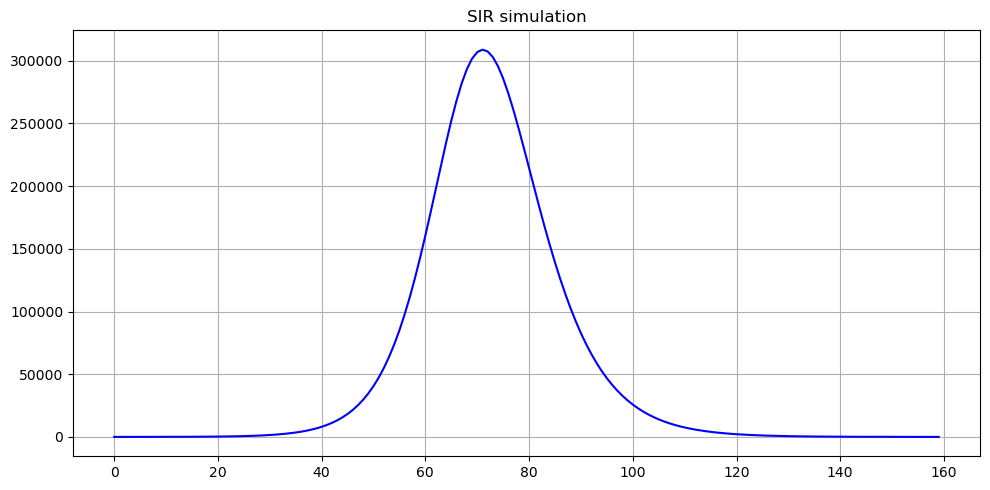

In [31]:
df['I'].plot(figsize=(10, 5), title=dataset,color='blue')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
#check if there are any negative infections observations
sum(df['I']<0)

0

## Model setup

In [5]:
#Population
N=4900000
N

4900000

In [6]:
n_days = len(df['I'])
times = np.arange(n_days)
t_0 = 0
I_begin = df['I'].iloc[0]
S_begin = N - I_begin
R_begin = df['R'].iloc[0]
new_I0 = pt.zeros_like(I_begin)

In [7]:
new_I0

Second.0

In [8]:
infected=df['I']

In [9]:
##This SI function is based on: 
# https://github.com/Priesemann-Group/covid19_inference/blob/master/covid19_inference/model/compartmental_models/SIR.py

def sir_func(S_t, I_t, new_I0, beta, gamma, N):
    new_I_t = beta * S_t * I_t / N
    new_R_t = gamma * I_t 
    S_t = S_t - new_I_t 
    I_t = I_t + new_I_t - new_R_t   
    I_t = pt.clip(I_t, -1, N)  # for stability
    S_t = pt.clip(S_t, 0, N)
    return S_t, I_t, new_I_t


In [10]:
## Define the model

In [11]:
# SIR function estimating S, I and R
##This function is based on: https://github.com/Priesemann-Group/covid19_inference/blob/master/covid19_inference/model/compartmental_models/SIR.py

def sir_func(S_t, I_t, new_I0, R_t, beta, gamma, N): #add R
#def sir_func(S_t, I_t, new_I0, beta, gamma, N):
    new_I_t = beta * S_t * ( I_t / N )
    new_R_t = gamma * I_t 
    S_t = S_t - new_I_t 
    I_t = I_t + new_I_t - new_R_t   
    R_t = R_t + new_R_t # add R_t
    
    #I_t = pt.clip(I_t, -1, N)  # for stability
    I_t = pt.clip(I_t, 0, N)  # for stability
    S_t = pt.clip(S_t, 0, N)
    R_t = pt.clip(R_t, 0, N) #add R_t
    
    #return S_t, I_t, new_I_t
    return S_t, I_t, new_I_t, R_t # add R

* Priors: assumed distributions and their parameters for the beta and gamma
* Taken from Semenova et al. (2020) paper at https://mc-stan.org/learn-stan/case-studies/boarding_school_case_study.html
* Their code in Rstats and STAN at https://github.com/charlesm93/disease_transmission_workflow/blob/main/full_case_study_final.Rmd
  
* __pt.zeros__ Variables, S, I and R are initialised as tensors with zero values for the model variables

* __pt.subtensor.inc_subtensor__ PyTensor expression used to initialize the values of the first element of tensors S and I (for Susceptible and Infected)

* __scan__ Like in TensorFlow, we have initiated a graph, this then iterates through the ODE as defined in __si_func__



In [16]:
with pm.Model() as mod:
    
    # Priors
    #beta = pm.Wald('beta', 1, 1)
    #gamma = pm.Wald('gamma', 1, 1)

    #beta = pm.Wald('beta', 2, 1)
    beta = pm.HalfNormal('beta',sigma=1) # match Semenova et al. priors
    
    gamma = pm.HalfNormal('gamma', sigma=1) # match Semenova et al. priors
    #gamma = pm.Wald('gamma', 1, 1)
    #gamma = pm.Normal('gamma', 0.4, 0.5) # match Semenova et al. priors
    
        # Variables
    S = pt.zeros(n_days)
    I = pt.zeros(n_days)
    R = pt.zeros(n_days)
    
    S = pt.subtensor.inc_subtensor(S[0], N - infected[0])
    I = pt.subtensor.inc_subtensor(I[0], infected[0])
    R = pt.subtensor.inc_subtensor(R[0], 0)
    
    #outputs, progress = scan(
    outputs, _ = scan(
        fn=sir_func,
        outputs_info=[S_begin, I_begin, new_I0, R_begin],
        non_sequences=[beta, gamma, N],
        n_steps=n_days
    )
    S_t, I_t, new_I_t, R_t = outputs
    
   
    # Likelihood
    phi_inv = pm.Exponential("phi_inv", 0.1)
    
    y = pm.NegativeBinomial("y", mu=I_t, alpha=phi_inv, observed=infected)
    
    R0 = pm.Deterministic("R0", beta/gamma)
    recovery_time = pm.Deterministic("recovery time", 1/gamma)
    
    S_t = pm.Deterministic("S_t", S_t)
    I_t = pm.Deterministic("I_t", I_t)
    R_t = pm.Deterministic("R_t", R_t)
    
# with open("sir_log.csv", mode="a", newline="") as file:
#     writer = csv.writer(file)
#     writer.writerow([S_t, I_t, new_I_t])
    
with mod:
    idata_log = pm.sample(1000, idata_kwargs={"log_likelihood": True}, chains=4)
    idata_log.extend(pm.sample_posterior_predictive(idata_log))

summ = az.summary(idata_log, hdi_prob=0.9)

# Get current time formatted as yyyy-mm-dd hh:mm:ss

current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(current_time)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, gamma, phi_inv]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.
Sampling: [y]


Output()

2025-07-09 16:22:16


## Model Output

In [17]:
az.summary(idata_log, var_names=["beta", "gamma", "R0", "recovery time"],hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.469,0.003,0.463,0.474,0.000,0.000,1301.0,1336.0,1.0
gamma,0.294,0.004,0.287,0.301,0.000,0.000,1297.0,1255.0,1.0
R0,1.596,0.011,1.577,1.613,0.000,0.000,1318.0,1304.0,1.0
recovery time,3.404,0.048,3.322,3.478,0.001,0.001,1297.0,1255.0,1.0


Note that $\beta = 0.5, \gamma  = \frac{1}{3}$ in the simulated data


In [18]:
summ

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.469,0.003,0.463,0.474,0.000,0.000,1301.0,1336.0,1.0
gamma,0.294,0.004,0.287,0.301,0.000,0.000,1297.0,1255.0,1.0
phi_inv,20.885,2.543,16.733,25.124,0.057,0.041,1961.0,1619.0,1.0
R0,1.596,0.011,1.577,1.613,0.000,0.000,1318.0,1304.0,1.0
recovery time,3.404,0.048,3.322,3.478,0.001,0.001,1297.0,1255.0,1.0
...,...,...,...,...,...,...,...,...,...
R_t[155],3189982.528,29611.446,3139836.360,3235047.149,813.783,575.983,1319.0,1304.0,1.0
R_t[156],3189987.621,29611.434,3139841.240,3235052.175,813.784,575.983,1319.0,1304.0,1.0
R_t[157],3189992.050,29611.424,3139845.482,3235056.548,813.784,575.983,1318.0,1304.0,1.0
R_t[158],3189995.902,29611.416,3139849.170,3235060.351,813.784,575.983,1319.0,1304.0,1.0


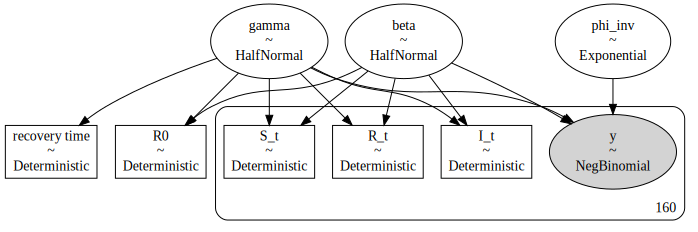

In [19]:
pm.model_to_graphviz(mod)

## Model Diagnostics

diagnostics from 
https://www.pymc.io/projects/examples/en/latest/case_studies/bayesian_workflow.html 
and Osvald, Chap 5

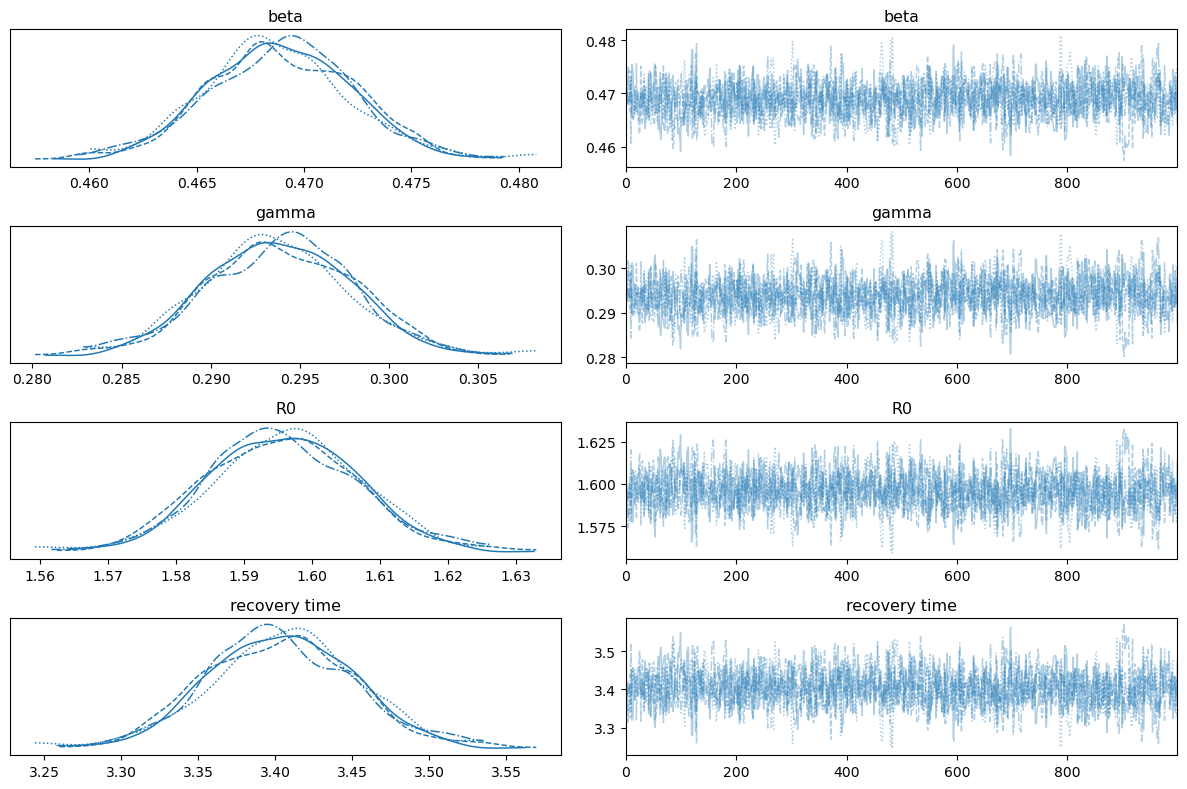

In [20]:
# Trace plots with chains separate
az.plot_trace(
    idata_log,
    var_names=["beta", "gamma", "R0", "recovery time"],
    #figsize=(10, 8),
    combined=False  # ensures chains are shown separately and colored
)
plt.tight_layout()
plt.show()


<Axes: >

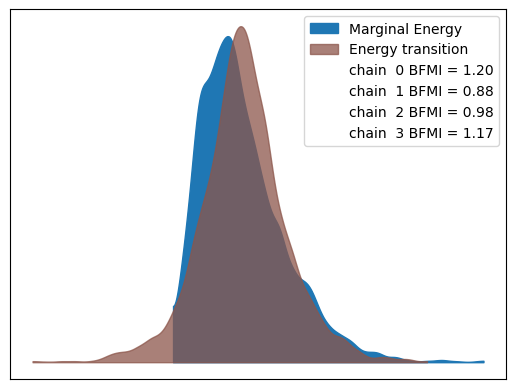

In [21]:
az.plot_energy(idata_log)

<Axes: title={'center': 'beta'}>

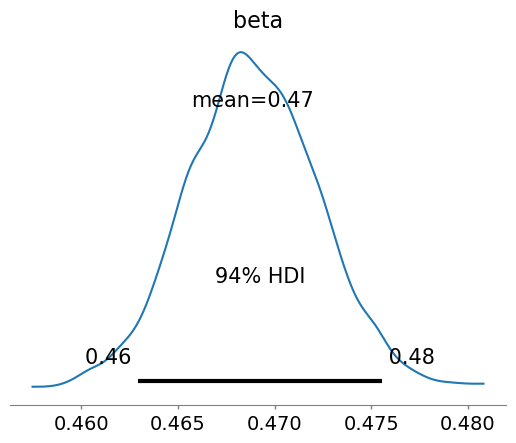

In [22]:
az.plot_posterior(idata_log, var_names=["beta"])

<Axes: title={'center': 'gamma'}>

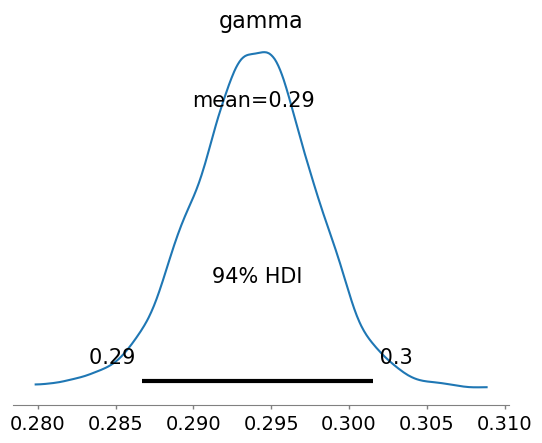

In [103]:
az.plot_posterior(idata_log, var_names=["gamma"])

<Axes: title={'center': 'R0'}>

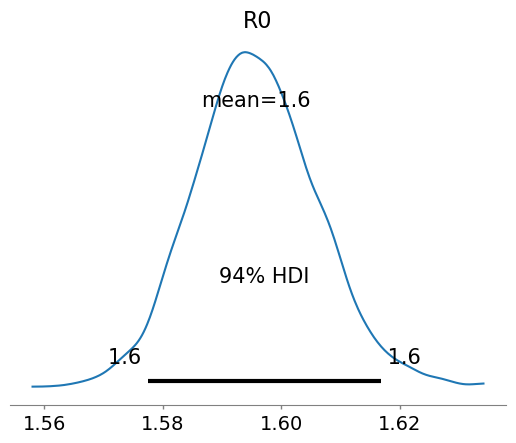

In [104]:
az.plot_posterior(idata_log, var_names=["R0"])

<Axes: title={'center': 'recovery time'}>

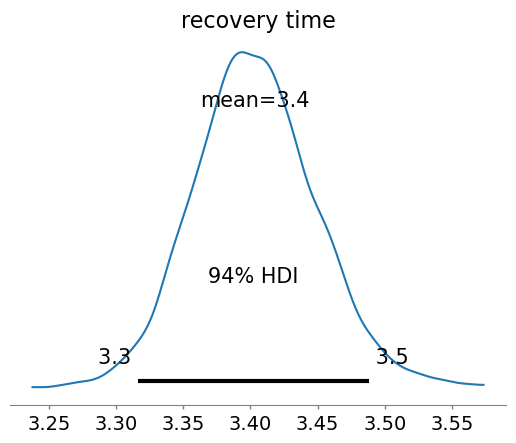

In [105]:
az.plot_posterior(idata_log, var_names=["recovery time"])

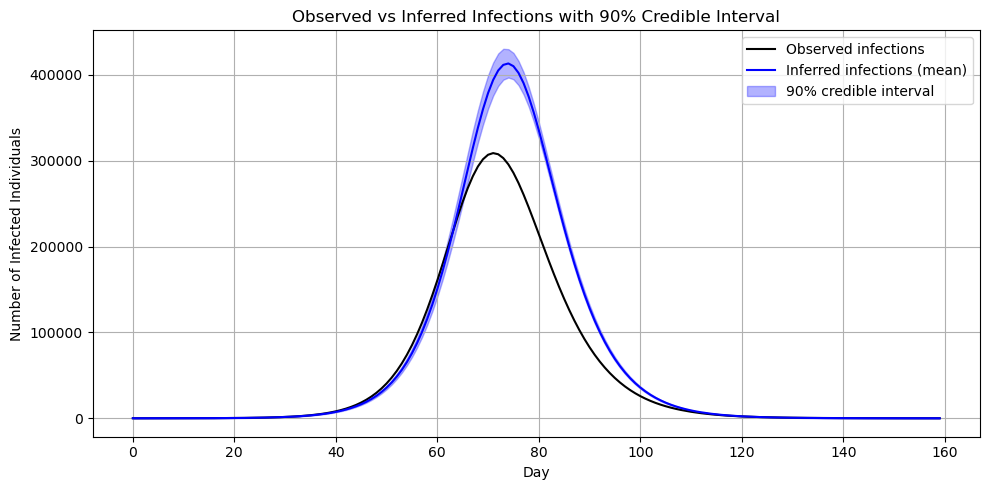

<Figure size 640x480 with 0 Axes>

In [23]:
# ----------------------------------------
# 1. Extract posterior samples of I_t
# ----------------------------------------

# Thin to reduce memory load if needed
idata_thin = idata_log.sel(draw=slice(None, None, 10))  # Optional: use if large memory use

# Stack samples across chains and draws
I_t_samples = idata_thin.posterior["I_t"].stack(sample=("chain", "draw")).values  # shape: [time, samples]

# ----------------------------------------
# 2. Compute Posterior Mean and 90% HDI
# ----------------------------------------
I_t_mean = np.mean(I_t_samples, axis=1)
I_t_lower = np.percentile(I_t_samples, 5, axis=1)
I_t_upper = np.percentile(I_t_samples, 95, axis=1)

# ----------------------------------------
# 3. Plot Observed vs Inferred Infections
# ----------------------------------------

# If you have the original observed data in a variable like `infected`:
days = np.arange(len(I_t_mean))  # or use actual time values if available

plt.figure(figsize=(10, 5))
plt.plot(days, infected, '-', label="Observed infections", color='black')
plt.plot(days, I_t_mean, label="Inferred infections (mean)", color='blue')
plt.fill_between(days, I_t_lower, I_t_upper, color='blue', alpha=0.3, label="90% credible interval")

plt.xlabel("Day")
plt.ylabel("Number of Infected Individuals")
plt.title("Observed vs Inferred Infections with 90% Credible Interval")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('sir_out.png')

In [109]:
waic = az.waic(idata_log)
waic

Computed from 4000 posterior samples and 160 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1292.66    41.71
p_waic        2.27        -

In [110]:
loo = az.loo(idata_log)
loo

Computed from 4000 posterior samples and 160 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1292.66    41.71
p_loo        2.27        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      160  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%